In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [4]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [68]:
# MLP revisited : Constructing a 2 layer MLP
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)*(5/3)/((n_embd * block_size)**0.5)
#b1 = torch.randn(n_hidden,                        generator=g) *0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) *0.01 
b2 = torch.randn(vocab_size,                      generator=g) *0 #logits close to 0

bngain=torch.ones((1,n_hidden))
bnbias=torch.zeros((1,n_hidden))
bnmean_running=torch.zeros((1,n_hidden))
bnstd_running=torch.ones((1,n_hidden))

parameters = [C, W1, W2, b2,bngain,bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [37]:
hpreact.shape

torch.Size([32, 200])

In [38]:
hpreact.mean(0,keepdim=True).shape

torch.Size([1, 200])

In [39]:
hpreact.std(0,keepdim=True).shape

torch.Size([1, 200])

In [69]:
# same optimization as last time i.e minibatch gradient Descent now with batch norm
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    #b1 has no need since we are subtracting in bnmeani so no use
  #bacthNorm with tracking mean and std
  bnmeani=hpreact.mean(0,keepdim=True)
  bnstdi=hpreact.std(0,keepdim=True)
  hpreact=bngain*(hpreact-bnmeani)/bnstdi + bnbias


  with torch.no_grad():
       bnmean_running = 0.999*bnmean_running+0.001*bnmeani
       bnstd_running=0.999*bnstd_running + 0.001*bnstdi
              
        
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


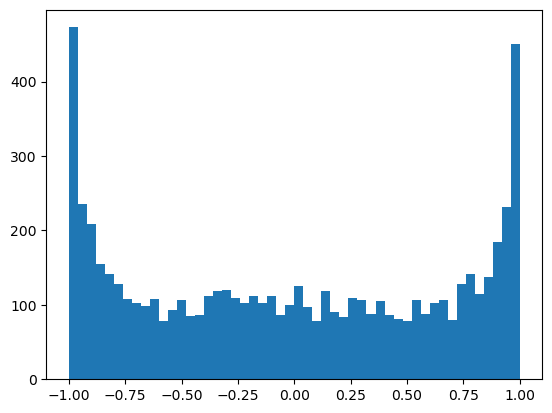

In [41]:
plt.hist(h.view(-1).tolist(),50);

In [ ]:
#logits[0]

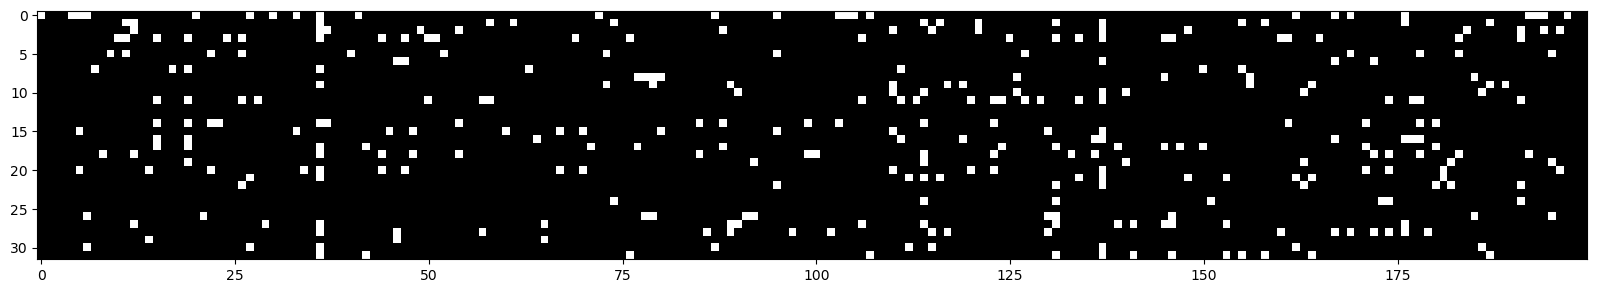

In [42]:
#Fixing the saturated tanh problem
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest')

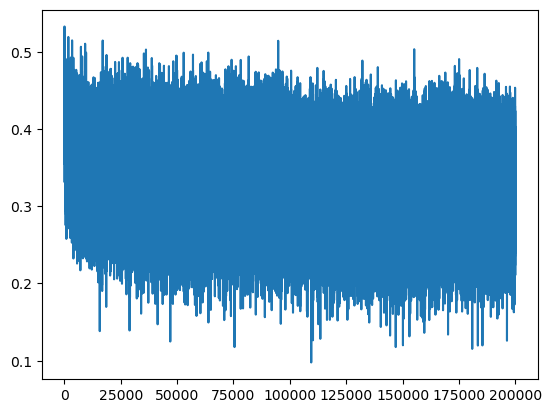

In [70]:
plt.plot(lossi)

In [44]:
#Fixing the intial loss
#At intialization we expect a uniform dist. of characters as output
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [45]:
#4 dimensional example of loss intialization issue
#logits=torch.tensor([0.0,0.5,0.0,0.0])
logits=torch.rand(4)*100
probs=torch.softmax(logits,dim=0)
loss=-probs[2].log()
logits,probs,loss

(tensor([70.3944, 15.3725, 31.5313, 88.9895]),
 tensor([8.3995e-09, 1.0680e-32, 1.1123e-25, 1.0000e+00]),
 tensor(57.4582))

In [48]:
#Calibarate the batchnorm at the end of training
#Fixing the input as batch problem of Batch Norm
#not required when mean and std calculated in running manner
with torch.no_grad():
    #pass the training set through
    emb=C[Xtr]
    embcat=emb.view(emb.shape[0],-1)
    hpreact=embcat@W1+b1
    #measuring the mean and std over entire training set
    bnmean=hpreact.mean(0,keepdim=True)
    bnstd=hpreact.std(0,keepdim=True)

In [71]:
#Evaluating the Training and Validation Loss 
@torch.no_grad()
def split_loss(split):
    x,y={
        'train': (Xtr,Ytr),
        'val' : (Xdev,Ydev),
        'test' : (Xte,Yte),
    }[split]
    #print(f"x shape: {x.shape}, y shape: {y.shape}")
    emb = C[x] 
    # print("C shape:", C.shape)
    #print("emb shape:", emb.shape)
    #print("Yb shape:", y.shape)
    embcat = emb.view(emb.shape[0], -1) 
    
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation

    #hpreact=bngain*(hpreact-bnmean)/bnstd + bnbias
    hpreact=bngain*(hpreact-bnmean_running)/bnstd_running + bnbias
   
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    #print("logits shape:", logits.shape)
    #print("Yb shape:", Yb.shape)
    loss = F.cross_entropy(logits, y) # loss function
    print(split,loss.item())

split_loss('train')
split_loss('val')

train 2.0674145221710205
val 2.1056840419769287


Training a Deeper Neural Net and Pytorchfying the Code


In [10]:
#Linear layer
class Linear :
    def __init__(self,fan_in,fan_out,bias=True):
        self.weight=torch.rand((fan_in,fan_out),generator=g)/fan_in**0.5 ##kaiming he intial.
        self.bias=torch.zeros(fan_out)if bias else None

    def __call__(self,x):
        self.out=x@self.weight
        if self.bias is not None:
            self.out+=self.bias
        return self.out
    def parameters(self):
        return [self.weight]+([]if self.bias is None else[self.bias])

class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
      #eps is the epsilion, momnetum is used to update the running mean and var
    self.eps = eps
    self.momentum = momentum
    self.training = True#used beacuse diff.when we train and when we inference 
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update and not with gradient update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
      #reason for using self.training=true
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    #normalization
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta#used for stats and grpahs visualization purposes
    # update the buffers
    if self.training:
      with torch.no_grad():#imp since we dont want a computational graph for them
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []


n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
    
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size), ]

with torch.no_grad():
  # last layer: make less confident
  #layers[-1].gamma *= 0.1
  layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

46497


In [11]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization



      0/ 200000: 3.2933


layer 1 (      Tanh): mean -0.50, std 0.31, saturated: 0.00%
layer 3 (      Tanh): mean -0.91, std 0.17, saturated: 62.19%
layer 5 (      Tanh): mean -0.98, std 0.11, saturated: 96.88%
layer 7 (      Tanh): mean -1.00, std 0.01, saturated: 97.25%
layer 9 (      Tanh): mean -1.00, std 0.00, saturated: 100.00%


Text(0.5, 1.0, 'activation distribution')

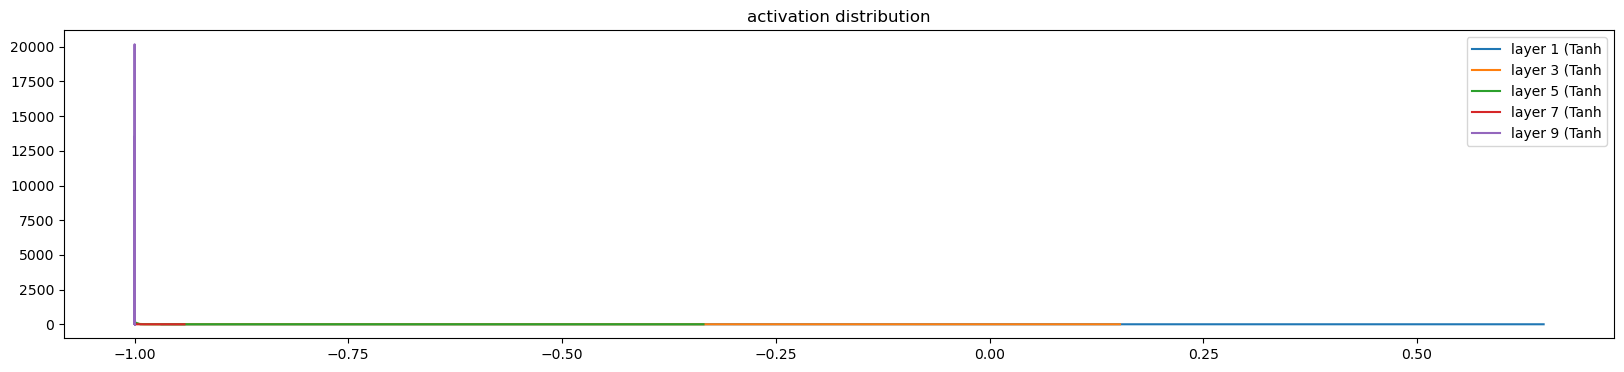

In [12]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.000000, std 1.830856e-07
layer 3 (      Tanh): mean +0.000000, std 3.734221e-08
layer 5 (      Tanh): mean +0.000000, std 8.861222e-09
layer 7 (      Tanh): mean -0.000000, std 1.981948e-07
layer 9 (      Tanh): mean -0.000098, std 2.157694e-04


Text(0.5, 1.0, 'gradient distribution')

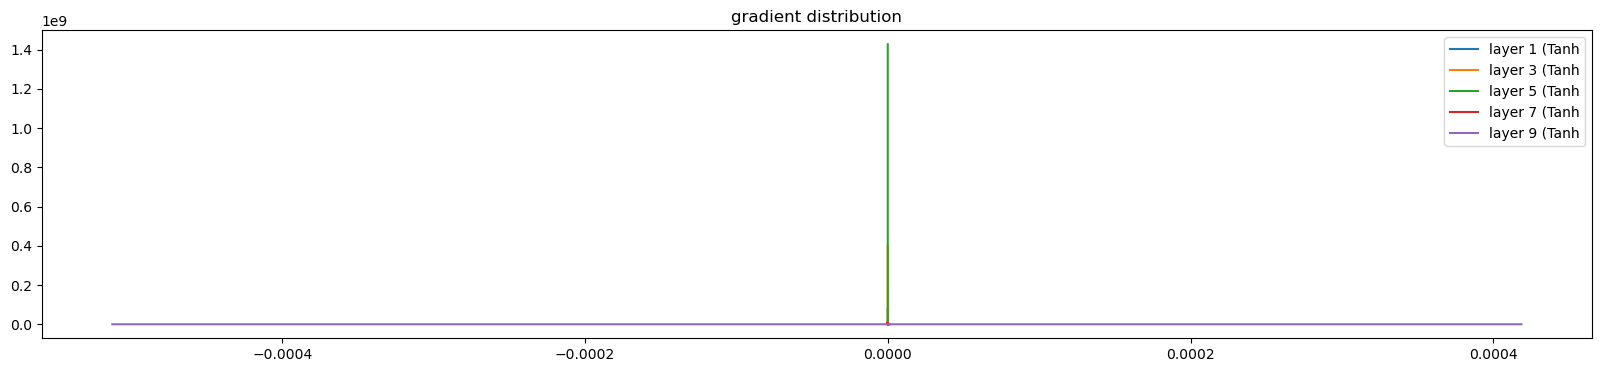

In [13]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000001 | std 2.894527e-06 | grad:data ratio 2.893720e-06
weight  (30, 100) | mean +0.000000 | std 1.064116e-06 | grad:data ratio 1.842281e-05
weight (100, 100) | mean -0.000000 | std 6.898714e-08 | grad:data ratio 2.383474e-06
weight (100, 100) | mean -0.000000 | std 4.483784e-09 | grad:data ratio 1.555664e-07
weight (100, 100) | mean -0.000000 | std 7.276668e-10 | grad:data ratio 2.514171e-08
weight (100, 100) | mean +0.000001 | std 4.074168e-07 | grad:data ratio 1.415551e-05
weight  (100, 27) | mean -0.000000 | std 4.525343e-02 | grad:data ratio 7.434364e+00


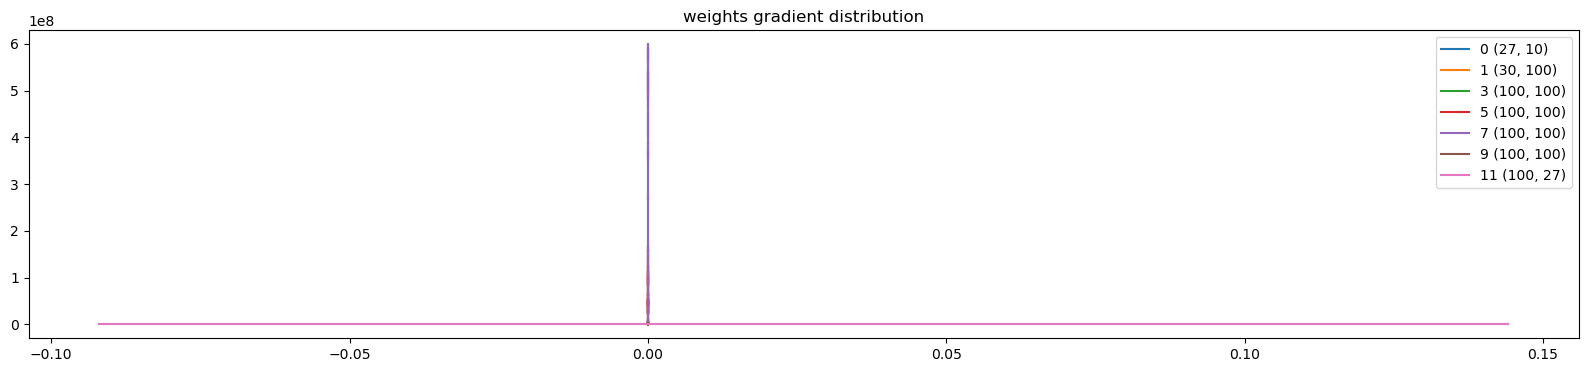

In [14]:


# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');



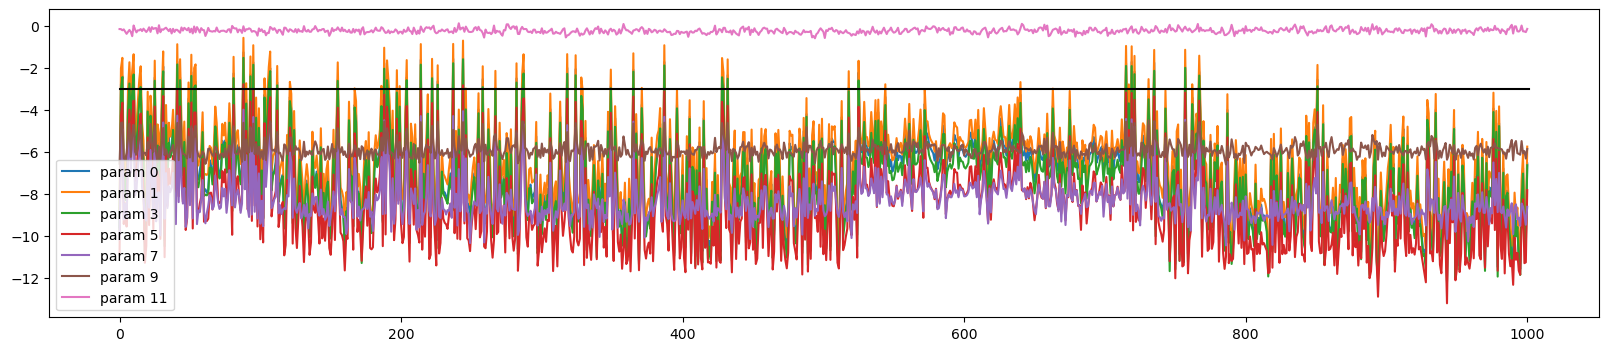

In [15]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [16]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.893864393234253
val 2.8884081840515137


In [17]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

eriaaimyazlreevvnd.
ryal.
.
eivrsjejdrleg.
.
dejedielii.
eli.
realeieinvananar.
eayzivhvkaa.
n.
sadbvrgahiries.
.
n.
jr.
eelvlxntpucfnu.
a.
nvd.
r.
yidue.
ehs.
